# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import math
import random
import umap
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/Users/ramtinsamavat/Desktop/intro til maskin/Assignment2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

### Set seeds for reproducibility

In [70]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load and preprocess data

In [71]:
data = pd.read_csv('nn_data.csv')

train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

X_train = train.drop(columns=['y', 'split'])
y_train = train['y']

X_test = test.drop(columns=['y', 'split'])
y_test = test['y']

# PyTorch models only operate on tensors.
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Wraps features and labels together to be used in PyTorch's dataloader.
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# The data is divided into batches to make the training faster and less memory heavy.
# Shuffling helps the model generalize better instead of just memorizing input order. No shuffle needed under evaluation.
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False) # Large batch size bcause no backpropagation happens during testing.

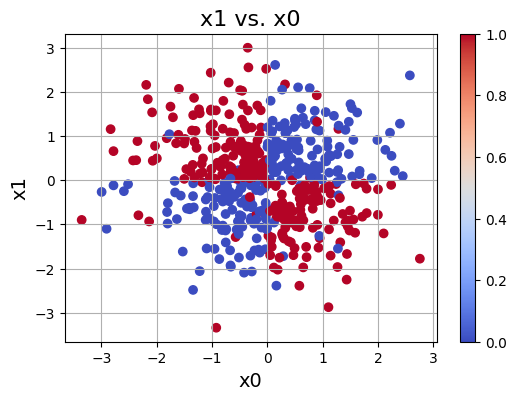

In [72]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

### Multi-Layer Perceptron (MLP) model

In [73]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    # The layers of the network as a sequential container.
    self.layer = nn.Sequential(
      nn.Linear(2, 128),        # Fully connected layer: input size 2, output size 128.
      nn.ReLU(),                # Activation function: ReLU introduces non-linearity
      nn.Linear(128, 128),      # Second fully connected layer: 128 inputs → 128 outputs
      nn.ReLU(),
      nn.Linear(128, 64),       # Third fully connected layer: 128 inputs → 64 outputs
      nn.ReLU(),
      nn.Linear(64, 1)          # Final layer: 64 inputs → 1 output (for binary decision)
    )

  # Defines how the input tensor flows through the network.
  def forward(self, x):
    # Pass the input through all layers sequentially
    # squeeze(1) removes extra dimension from output. Needed for binary classification so that output match target tensor shape.
    return self.layer(x).squeeze(1)

model = MLP()

### Optimizer and scheduler

#### Learning rate scheduler

The learning rate is an essential aspect of training models. It determines how much a model's weights are adjusted with respect to the loss gradient during each iteration of training. A too high learning rate can make the model go off track because the weight adjustments are too large, while a too low learning rate makes training slow and may get stuck in local minima. Learning rate schedulers dynamically adjust the learning rate during training, helping the model learn faster and reach a better solution.



In [74]:

# The Adam optimization algorithm adapts the learning rate for each parameter individually based on gradients.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

criterion = nn.BCEWithLogitsLoss() # The loss function.

# Manual learning rate scheduler with warmup and cosine decay.
def lr_lambda(current_step, warmup_steps=200, total_steps=2000):

  # Gradually increase the learning rate in the warmup phase.
  if current_step < warmup_steps:
    return float(current_step) / float(max(1, warmup_steps))

  # Slowly reduce learning rate following a cosine curve.
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return 0.5 * (1 + math.cos(math.pi * progress)) # Cosine decay returned

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Training loop

In [75]:

best_accuracy = 0
best_model_state = None
lr_history = [] # Used for plotting learning rate at each step

epochs = 200

for epoch in range(epochs):
  model.train() # set model to training mode.

  # Loop over bathes from the training DataLoader.
  for x_batch, y_batch in train_dl:
    optimizer.zero_grad() # Clearing previous gradients.
    prediction = model(x_batch) # Prediction for the current batch.
    loss = criterion(prediction, y_batch)
    loss.backward() # Backpropagate gradients
    optimizer.step() # Update model weights using optimizer.
    scheduler.step() # Update learning rate.

    lr_history.append(optimizer.param_groups[0]['lr']) # Save current learning rate.

  # Evaluate performance on the test set after each epoch
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # disable gradient calculations for efficiency.
    prediction = torch.sigmoid(model(X_test)) # sigmoid to get probabilities.
    accuracy = ((prediction > 0.5).float() == y_test).float().mean().item() # test accuracy

  print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Test Acc: {accuracy:.4f}")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model_state = model.state_dict()

Epoch 1/200 - Loss: 0.6987 - Test Acc: 0.4560
Epoch 2/200 - Loss: 0.6933 - Test Acc: 0.4960
Epoch 3/200 - Loss: 0.6874 - Test Acc: 0.5560
Epoch 4/200 - Loss: 0.6865 - Test Acc: 0.6240
Epoch 5/200 - Loss: 0.6724 - Test Acc: 0.6820
Epoch 6/200 - Loss: 0.6675 - Test Acc: 0.7280
Epoch 7/200 - Loss: 0.6493 - Test Acc: 0.7760
Epoch 8/200 - Loss: 0.6260 - Test Acc: 0.8260
Epoch 9/200 - Loss: 0.6010 - Test Acc: 0.8600
Epoch 10/200 - Loss: 0.5466 - Test Acc: 0.8660
Epoch 11/200 - Loss: 0.5477 - Test Acc: 0.8720
Epoch 12/200 - Loss: 0.4619 - Test Acc: 0.8900
Epoch 13/200 - Loss: 0.4450 - Test Acc: 0.9000
Epoch 14/200 - Loss: 0.4759 - Test Acc: 0.8980
Epoch 15/200 - Loss: 0.3595 - Test Acc: 0.9120
Epoch 16/200 - Loss: 0.4538 - Test Acc: 0.8920
Epoch 17/200 - Loss: 0.2354 - Test Acc: 0.9200
Epoch 18/200 - Loss: 0.5161 - Test Acc: 0.9100
Epoch 19/200 - Loss: 0.3592 - Test Acc: 0.9120
Epoch 20/200 - Loss: 0.2612 - Test Acc: 0.9040
Epoch 21/200 - Loss: 0.3414 - Test Acc: 0.8980
Epoch 22/200 - Loss: 0

### Final evaluation

In [76]:
model.load_state_dict(best_model_state)
print(f"Best Test Accuracy: {best_accuracy:.3f}")

Best Test Accuracy: 0.926


### Network Architecture & Decision Boundary

**The architecture:**

| Layer    | Type            | Input dimension | Output dimension | Activation |
|----------|-----------------|-----------------|------------------|------------|
| Hidden 1 | Fully connected | 2               | 128              | ReLU       |
| Hidden 2 | Fully connected | 128             | 128              | ReLU       |
| Hidden 3 | Fully connected | 128             | 64               | ReLU       |
| Output   | Fully connected | 64              | 1                | None       |

Input (2) → Linear(2, 128) → ReLU → Linear(128, 128) → ReLU → Linear(128, 64) → ReLU → Linear(64, 1)

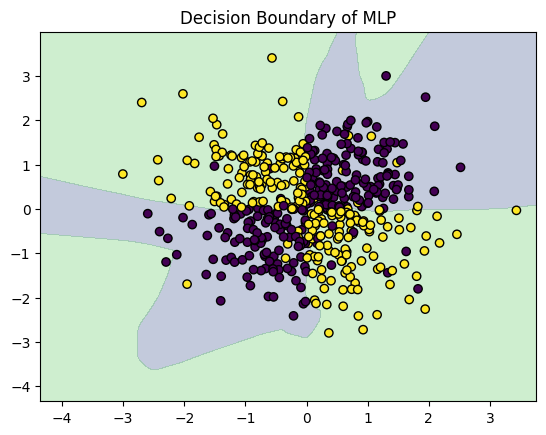

In [77]:
# Create grid
x_min, x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
y_min, y_max = X_train[:,1].min()-1, X_train[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Predict
with torch.no_grad():
  zz = torch.sigmoid(model(grid)).reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='k')
plt.title("Decision Boundary of MLP")
plt.show()

### Learning rate curve

**Did the learning rate scheduling improve performance? Why or why not?**

When comparing runs with and without the scheduler, the improvement in test accuracy was small. This is likely due ti the use of the Adam optimizer, which provides both adaptive learning rates for each parameter and stable convergence without external scheduling. On larger datasets or with longer training, the scheduler may have a more noticeable impact.


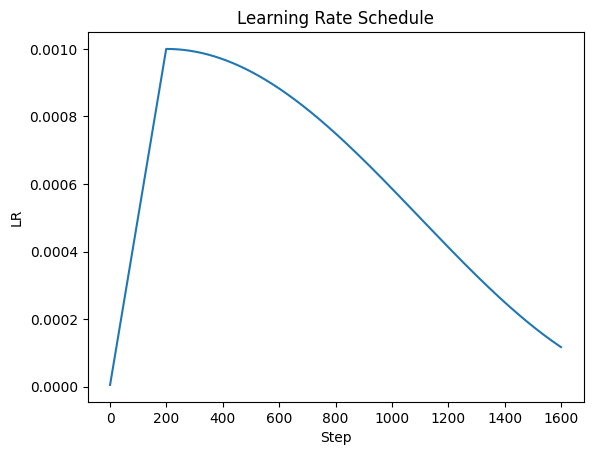

In [78]:
plt.plot(lr_history)
plt.title("Learning Rate Schedule")
plt.xlabel("Step")
plt.ylabel("LR")
plt.show()

### Discussion

**How can you make sure the results are reproducible?**

- We can ensure that results are reproducible by setting fixed random seeds for all libraries used during training. Specifying a seed provides a consistent starting point for all random operations, such as weight initialization, data shuffling, and dropout. This guarantees that the model produces the same results each time it is executed under identical conditions.

**Which optimizer did you choose? Discuss the differences between SGD and Adam.**

- The chosen optimizer was Adam. Using Adam, the model was able to surpass the required accuracy, reaching 0.932 on the best run. In contrast, training with SGD did not exceed 0.914 accuracy. The main difference between the two optimizers is that Adam utilizes an adaptive learning rate for each parameter, while SGD uses a single, fixed global learning rate for all parameters. In this model, Adam’s adaptive property made it a more suitable choice.

**Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.**

| Configuration       | Change                              | Test Accuracy |
|---------------------|-------------------------------------|---------------|
| Base                | 3 hidden layers, Adam, LR scheduler | 0.926         |
| No manual scheduler | Base LR remains constant            | 0.922         |
| 2 hidden layers     | Smaller network                     | 0.914         |
| SGD optimizer       | Adam → SGD                          | 0.912         |


# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle. When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [4]:
# Hmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)

In [4]:
data.head()

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765


In [5]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


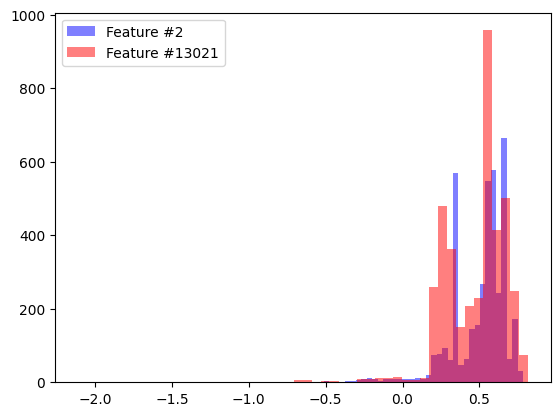

In [6]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

In [7]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7


### Prepare the data

#### Scaling

Scaling enures all features contribute equally regardless of their original numeric range. This is helpful when for dimensionality reduction methods that rely on distances or variance.




In [6]:
X = data.iloc[:, 1:].values # Take all columns except the first one. The first colum is ID.

scaler = StandardScaler() # standardizes features to have mean = 0 and standard deviation = 1.
X_scaled = scaler.fit_transform(X)

print(X_scaled.shape)

(4000, 16384)


### Dimensionality reduction

#### PCA

In [82]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Reduced shape:", X_pca.shape)

Reduced shape: (4000, 50)


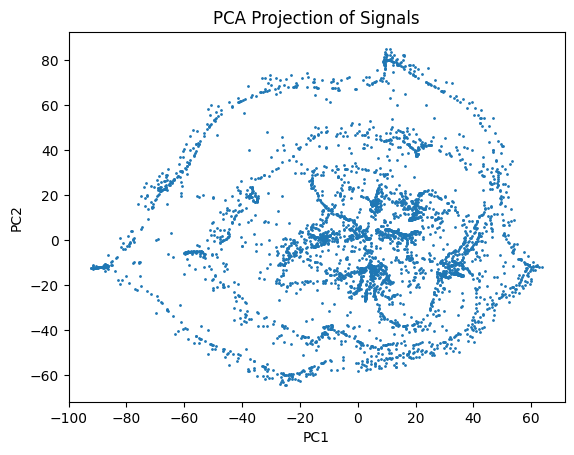

In [83]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)
plt.title("PCA Projection of Signals")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

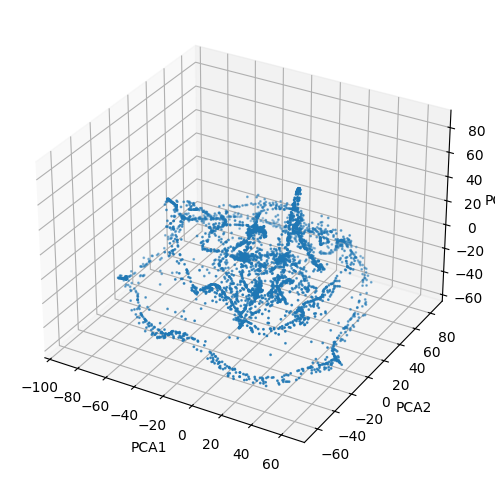

In [84]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=1)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

#### t-SNE

In [7]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42) # Reducing high dimensional data to 3 dimensions.
X_tsne = tsne.fit_transform(X)
print("Reduced shape:", X_tsne.shape)

Reduced shape: (4000, 3)


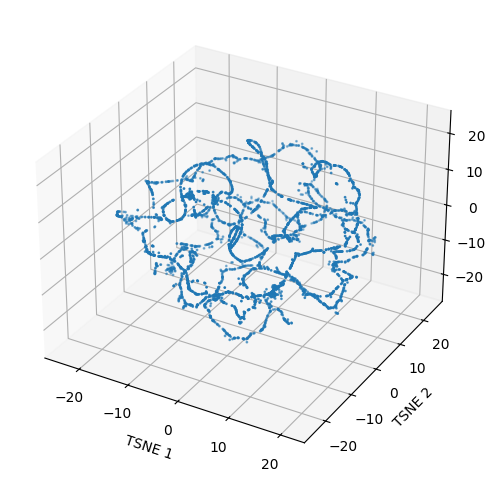

In [86]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], s=1)
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.set_zlabel('TSNE 3')
plt.show()

#### UMAP

In [87]:
reducer = umap.UMAP(
    n_neighbors=30,   # number of local neighbors
    n_components=3,   # reduce to 2D for visualization
    min_dist=0.1,     # controls how tightly points are packed
    random_state=42
)
X_umap = reducer.fit_transform(X_scaled)
print("Reduced shape:", X_umap.shape)

/Users/ramtinsamavat/Desktop/intro til maskin/Assignment2/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reduced shape: (4000, 3)


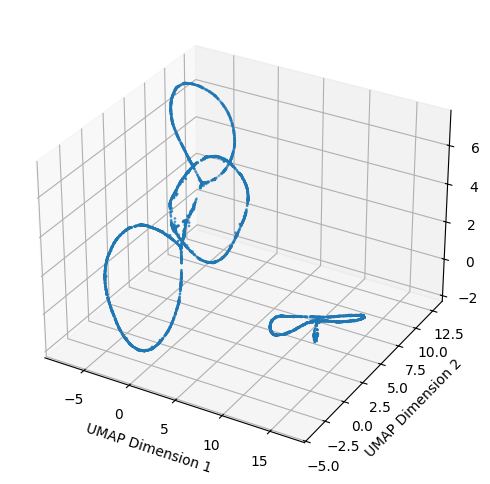

In [89]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_umap[:,0], X_umap[:,1], X_umap[:,2], s=1)
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")
plt.show()

### Clustering with KMeans and PCA

#### Determine the number of clusters

The silhouette score is a metric used for evaluating the quality of clusters. It ranges from -1 to 1, where a higher silhouette score indicates that points are well-matched to their own cluster and poorly matched to neighboring clusters, implying better-defined clusters.

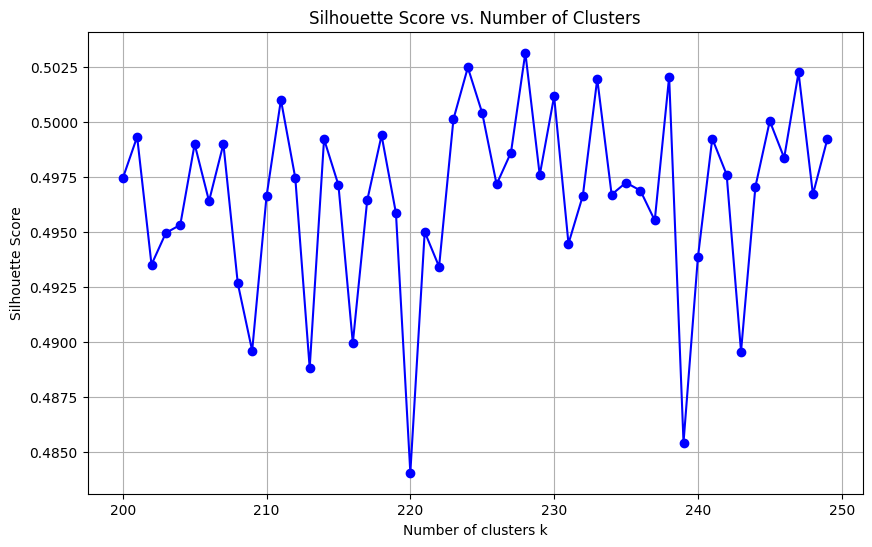

In [15]:
silhouette_scores = [] # The silhouette scores for each value of k.

k_values = range(200, 250) # The range for number of clusters to test.

# Iterate over different k values and calculate silhouette score for each k.
for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Instance of the KMeans clustering model.
  cluster_labels = kmeans.fit_predict(X_pca) # Train and assign each data point to a cluster.
  silhouette_scores.append(silhouette_score(X_pca, cluster_labels)) # Calculate the score for the current clustering.

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [16]:
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

Optimal number of clusters based on silhouette score: 228


#### Implement KMeans

In [17]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters_kmeans = kmeans.fit_predict(X_pca)

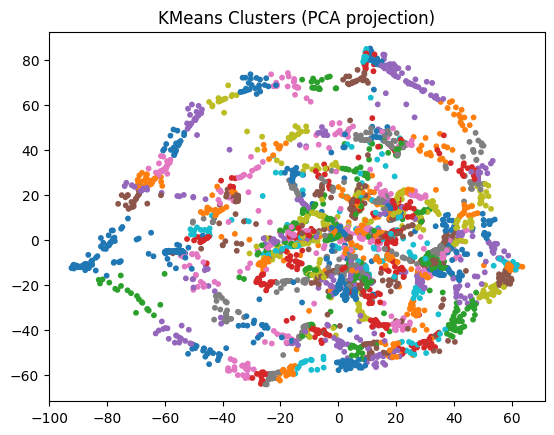

In [18]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap='tab10', s=10)
plt.title("KMeans Clusters (PCA projection)")
plt.show()

### Clustering with DBSCAN and t-SNE (final solution)

In [8]:
dbscan = DBSCAN(eps=3, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X_tsne)
print("Clusters found: ", len(set(clusters_dbscan)))

Clusters found:  4


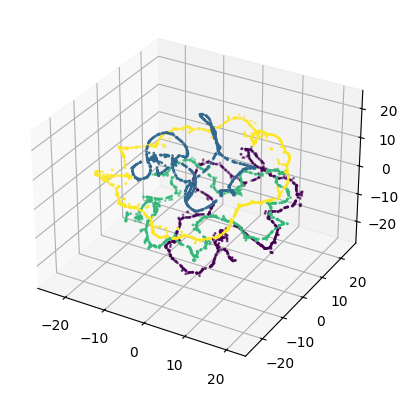

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=clusters_dbscan, s=1)
plt.show()

### Prepare Kaggle submission

In [97]:
submission = pd.DataFrame({
  'ID': np.arange(len(clusters_dbscan)),
  'cluster': clusters_dbscan
})
submission.to_csv('submission.csv', index=False)
print("Saved submission.csv for Kaggle upload.")

Saved submission.csv for Kaggle upload.


### Find the precise locations of the servers

Identify the server locations.
List the specific facilities in Trondheim and explain how you deduced their locations.

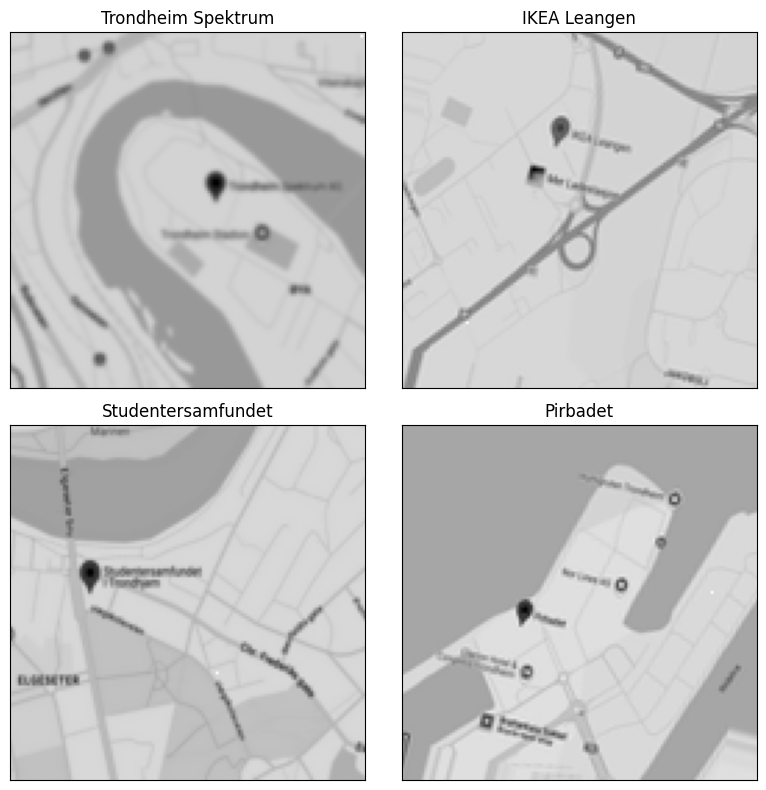

In [44]:
# Read column headers to determine the correct feature order
with open("unsupervised_data.csv") as f:
  column_headers = f.readline().split(',')

# Extract numeric indices from column names
column_indices = np.array([int(name[4:]) for name in column_headers])

# Sort columns to restore spatial structure
sorted_column_indices = np.argsort(column_indices)

# Reshape the dataset into 128x128 grids
feature_data = data.drop(columns='ID').to_numpy()
images_128x128 = feature_data[:, sorted_column_indices].reshape(-1, 128, 128)

# Labels for the pictures
labels = {
  5: "Trondheim Spektrum",  # Cluster 0
  11: "IKEA Leangen",       # Cluster 1
  24: "Studentersamfundet", # Cluster 2
  20: "Pirbadet",           # Cluster 3
}

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i, (row_id, location_name) in enumerate(labels.items()):
  axes[i].imshow(images_128x128[row_id], cmap="gray")
  axes[i].grid(False)
  axes[i].set_title(location_name)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Discussion

**_Dimensionality Reduction_: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.**

The dimensionality reduction method t-SNE was used to determine the correct number of clusters. t-SNE worked better than PCA because it can capture non-linear patterns in the data. It also worked better than UMAP in this case because t-SNE focuses more strongly on preserving local structure.

PCA, t-SNE, and UMAP all aim to reduce the number of dimensions in a dataset, but they use different approaches and serve different purposes.

PCA (Principal Component Analysis) is a linear method that finds the directions of maximum variance in the data and projects the data onto these directions. It preserves the global structure of the data and is fast, making it good for preprocessing high-dimensional data before clustering or other analysis. However, it only captures linear relationships, so complex, non-linear patterns may be missed.

t-SNE is a non-linear method that uses conditional probability to determine similarities between data points. It preserves local relationships, meaning that points that are close in high-dimensional space stay close in the low-dimensional embedding. t-SNE creates clear and well-separated clusters when reducing data to lower dimensions for visualization, but it changes the overall distances between points and can be slow on large datasets.

UMAP is also non-linear but faster and more scalable than t-SNE. It preserves both local and some global structure, aiming to balance both and provide a more representative overview of the data's relationships.

**_Clustering Approach_: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.**

DBSCAN was used as the clustering algorithm with hyperparameters epsilon = 3 and minimum samples = 10. The epsilon value is the maximum distance between two points to be considered neighbors, and minimum samples is the minimum number of points required to form a dense region.

This dataset contains clusters with ring-like or irregular shapes, where points within each ring are close together. DBSCAN is well-suited for this because it groups nearby points into the same cluster based on density, so each ring naturally forms one cluster. In this case, DBSCAN was a better choice than KMeans because it can find clusters of arbitrary shapes and does not require specifying the number of clusters beforehand. KMeans, on the other hand, works best for well-separated, spherical clusters centered around a centroid with a pre-defined number of clusters.

**_Server Locations_: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.**

The dataset consists of 4000 rows and 16,384 columns, representing flattened 128×128 grids for each observation. The column names encode the correct spatial ordering, allowing the rows to be reshaped into 2D grids.

Clustering revealed redundancy in the data, with multiple rows corresponding to the same server. By manually inspecting representative rows from each cluster, we identified the servers at the following locations: Trondheim spektrum, IKEA Leangen, Studentersamfundet, and Pribadet.

**_Data Type Analysis_: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?**

The hidden data type is an image, where each row in the dataset represents a flattened 128x128 pixel image. Knowing this is crucial because mages have strong spatial correlations, meaning neighboring pixels tend to have similar values. Flattening destroys this structure, making it harder for linear methods like PCA to capture meaningful patterns. Non-linear methods like t-SNE and UMAP work better because they can preserve local relationships between pixels, revealing clearer clusters that correspond to different images patterns.


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [2]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [3]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(1.0)

In [4]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.3333333333333333)

In [5]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.5)